In [2]:
from src.restricted_adversary_entropy import Q_FP_exact_hypergeometric_chernoff, optimize_L_val
import numpy as np
from math import log2
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Helvetica',
        'size'   : 7}
mpl.rc('font', **font)

# Actual experiment

### Weak source $\alpha>0.5$

In [3]:
# XEB threshold
chi = 0.585 # Our samples have XEB that rounds up to 0.586, so when bounding entropy we should round it down.
# Number of qubits
n = 64
# Total number of samples
L = 23651
# Number of validation samples
L_val = 11961
# Average time on a quantum computer
latency = 0.03
# Minimum distance of the adversary from the verifier
d_in_kms = 3000
# Time cost for validating one circuit on Aurora
t_val_one = 9.8 * 10**5 / (10624 * 6 * 2)

epsilon_2 = epsilon_ts = 10**-8
num_seeded_extraction_rounds = 10**8
epsilon_seeded = 10**-16

# Soundness security parameter
epsilon_sous = [10**-3, 10**-6]
# Adversary computational power in multiples of Aurora
As = [300, 40, 5]
for epsilon_sou in epsilon_sous:
    for A in As:
        # Adversary classical simulation fidelity
        PhiC = A * latency / t_val_one
        PhiC *= (1 - 2 * d_in_kms * 1000 / (3*10**8 * latency))
        epsilon_accept = epsilon_sou
        epsilon_smooth = (epsilon_sou - 2*epsilon_2 - 2*epsilon_ts - num_seeded_extraction_rounds * epsilon_seeded) / 6
        assert epsilon_smooth > 0
        Qmin = Q_FP_exact_hypergeometric_chernoff(epsilon_accept, chi=chi, L_val=int(L_val), L=L, PhiC=PhiC)
        H = Qmin * (n - 1) + log2(epsilon_sou) - 2
        print(f'Soundness: {epsilon_sou}, adversary: {A} times Aurora, entropy rate: {H / (L * n)}, entropy: {H}')


epsilon_2 = epsilon_ts = 10**-16
num_seeded_extraction_rounds = 10**8
epsilon_seeded = 10**-24

# Soundness security parameter
epsilon_sous = [10**-12]
# Adversary computational power in multiples of Aurora
As = [300, 40, 5]
for epsilon_sou in epsilon_sous:
    for A in As:
        # Adversary classical simulation fidelity
        PhiC = A * latency / t_val_one
        PhiC *= (1 - 2 * d_in_kms * 1000 / (3*10**8 * latency))
        epsilon_accept = epsilon_sou
        epsilon_smooth = (epsilon_sou - 2*epsilon_2 - 2*epsilon_ts - num_seeded_extraction_rounds * epsilon_seeded) / 6
        assert epsilon_smooth > 0
        Qmin = Q_FP_exact_hypergeometric_chernoff(epsilon_accept, chi=chi, L_val=int(L_val), L=L, PhiC=PhiC)
        H = Qmin * (n - 1) + log2(epsilon_sou) - 2
        print(f'Soundness: {epsilon_sou}, adversary: {A} times Aurora, entropy rate: {H / (L * n)}, entropy: {H}')

Soundness: 0.001, adversary: 300 times Aurora, entropy rate: 0.1339696486246058, entropy: 202785.03421571534
Soundness: 0.001, adversary: 40 times Aurora, entropy rate: 0.47904821295592376, entropy: 725118.0342157154
Soundness: 0.001, adversary: 5 times Aurora, entropy rate: 0.5283689340670819, entropy: 799773.0342157154
Soundness: 1e-06, adversary: 300 times Aurora, entropy rate: 0.10803326790584349, entropy: 163526.06843143067
Soundness: 1e-06, adversary: 40 times Aurora, entropy rate: 0.4577317478855484, entropy: 692852.0684314307
Soundness: 1e-06, adversary: 5 times Aurora, entropy rate: 0.508800545187988, entropy: 770153.0684314307
Soundness: 1e-12, adversary: 300 times Aurora, entropy rate: 0.07156022529627537, entropy: 108318.13686286136
Soundness: 1e-12, adversary: 40 times Aurora, entropy rate: 0.42787642228583184, entropy: 647661.1368628613
Soundness: 1e-12, adversary: 5 times Aurora, entropy rate: 0.4814008504284051, entropy: 728679.1368628613


# Infinite samples, fidelity vs verification advantage $\xi$ target entropy rate 0.04 (supplement)

In [4]:
n = 64
phis = np.arange(1, 0, -0.025) # Quantum device fidelity
pfail = 10**-4 # False negative rate
target_entropy_rate = 0.04
epsilon_sous = [10**-14, 10**-8, 10**-6, 10**-4, 10**-3]
# epsilon_sous = [10**-6]

L_val_min = 100
L_val_max = 5000000
n_points = 10

all_xis = []
for epsilon_sou in epsilon_sous:
    xis = []
    xi_max = 10**8
    xi_min = 0
    for phi in tqdm(phis):
        xi = xi_max
        tmp, R_Q = optimize_L_val(pfail, epsilon_sou, phi, xi, L_val_min, L_val_max, n_points)
        entropy_rate = R_Q * (n - 1) / n
        if entropy_rate < target_entropy_rate:
            xis.append(np.nan)
            continue

        i = 0
        high = xi_max
        low = xi_min
        result = np.nan
        while low <= high and i < 100:
            i += 1
            xi = (high + low) / 2
            tmp, R_Q = optimize_L_val(pfail, epsilon_sou, phi, xi, L_val_min, L_val_max, n_points)
            ans = R_Q * (n - 1) / n
            if np.isnan(ans):
                raise ValueError("CDF is nan")
            error = (ans - target_entropy_rate) / target_entropy_rate
            if error < -0.01:
                low = xi
            elif error > 0.01:
                high = xi
            elif np.abs(error) < 0.01:
                result = xi
                break
        
        xis.append(result)
        xi_min = result / 2
    all_xis.append(xis)

100%|██████████| 40/40 [00:04<00:00,  9.67it/s]


### Supplementary figure 17a

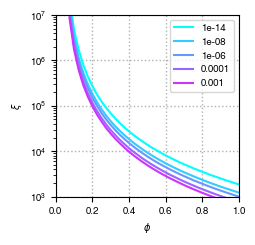

In [5]:
mm = 1/25.4  # centimeters in inches
fig1, ax1 = plt.subplots(figsize=(60 * mm, 60 * mm))
for i, (epsilon_sou, xis) in enumerate(zip(epsilon_sous, all_xis)):
    ax1.plot(phis, xis, color=cm.cool(i/(len(epsilon_sous))), label=f'{epsilon_sou}')
    
ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel(r'$\xi$')
ax1.set_yscale('log')
ax1.set_xlim(0, 1)
ax1.set_ylim(10**3, 10**7)
ax1.grid(which='major', linestyle=':', linewidth=1)
plt.legend()
# plt.savefig('restricted_adversary_xi_vs_phi.pdf')

## Validation cost vs fidelity supplement figure 17b

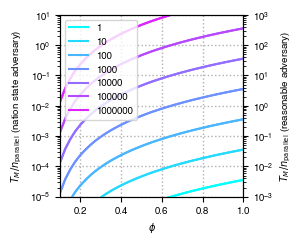

In [6]:
i = np.argwhere(np.abs(np.array(epsilon_sous) - 10**-6) < 0.000000000001)[0][0]
xis = np.array(all_xis[i]) # xis for security 10^-6
C_adv_nation = 10**5 # in unit of GPUs
C_adv_reasonable = 10**3

mm = 1/25.4  # centimeters in inches
fig1, ax1 = plt.subplots(figsize=(60 * mm, 60 * mm))
ax2 = ax1.twinx()
validation_GPU_hours_list = 10**np.arange(0, 7) # GPU hours = C_val * T_val / 3600
# validation_GPU_hours_list = [2.5, 10, 50, 200, 500, 2000, 5000, 20000, 50000, 200000, 500000, 2000000]
for i, validation_GPU_hours in enumerate(validation_GPU_hours_list):
    T_M_div_n_parallel_nation = 3600 * validation_GPU_hours / (C_adv_nation * xis) # T_M / N = C_val * T_val / (C_adv * xi)
    T_M_div_n_parallel_reasonable = 3600 * validation_GPU_hours / (C_adv_reasonable * xis)
    ax1.plot(phis, T_M_div_n_parallel_nation, color=cm.cool(i/(len(validation_GPU_hours_list))), label=f'{validation_GPU_hours}')
    ax2.plot(phis, T_M_div_n_parallel_reasonable, color=cm.cool(i/(len(validation_GPU_hours_list))), label=f'{validation_GPU_hours}')

ax1.grid(which='major', linestyle=':', linewidth=1)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlim(0.1, 1)
ax2.set_xlim(0.1, 1)
ax1.set_ylim(10**-5, 10**1)
ax2.set_ylim(10**-3, 10**3)
ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel(r'$T_M/n_{\rm parallel}$ (nation state adversary)')
ax2.set_ylabel(r'$T_M/n_{\rm parallel}$ (reasonable adversary)')
plt.legend()
# plt.savefig('restricted_adversary_latency_vs_fidelity.pdf')

### Validation cost vs fidelity main

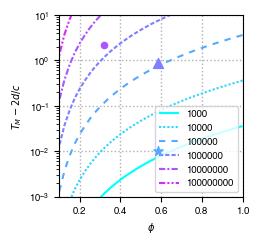

In [7]:
i = np.argwhere(np.abs(np.array(epsilon_sous) - 10**-6) < 0.000000000001)[0][0]
xis = np.array(all_xis[i]) # xis for security 10^-6
C_adv_nation = 10**5 # in unit of GPUs
C_adv_reasonable = 10**3

mm = 1/25.4  # centimeters in inches
fig1, ax1 = plt.subplots(figsize=(60 * mm, 60 * mm))
validation_GPU_hours_list = 10**np.arange(3, 9) # GPU hours = C_val * T_val / 3600
# validation_GPU_hours_list = [2.5, 10, 50, 200, 500, 2000, 5000, 20000, 50000, 200000, 500000, 2000000]
linestyles = [
     ('solid',                 (0, (1, 0))),
     ('densely dotted',        (0, (1, 1))),
     ('densely dashed',        (0, (3, 3))),
     ('densely dashed',        (0, (2, 1))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
for i, validation_GPU_hours in enumerate(validation_GPU_hours_list):
    T_M_div_n_parallel_nation = 3600 * validation_GPU_hours / (C_adv_nation * xis) # T_M / N = C_val * T_val / (C_adv * xi)
    ax1.plot(phis, T_M_div_n_parallel_nation, linestyle=linestyles[i][1], color=cm.cool(i/(len(validation_GPU_hours_list))), label=f'{validation_GPU_hours}')

d = 3000 * 1000
c = 3*10**8
ax1.scatter(0.32, 2.15 - 2*d/c, marker='.', s=80, zorder=100, color=cm.cool(4/6))
ax1.scatter(0.586, 0.913 - 2*d/c, marker='^', s=50, zorder=100, color=cm.cool(3/6))
ax1.scatter(0.586, 0.03 - 2*d/c, marker='*', s=50, zorder=100, color=cm.cool(2/6))
ax1.grid(which='major', linestyle=':', linewidth=1)
ax1.set_yscale('log')
ax1.set_xlim(0.1, 1)
ax1.set_ylim(10**-3, 10**1)
ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel(r'$T_M-2d/c$')
plt.legend()
# plt.savefig('restricted_adversary_latency_vs_fidelity_main.pdf')